# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

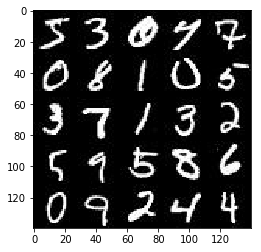

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

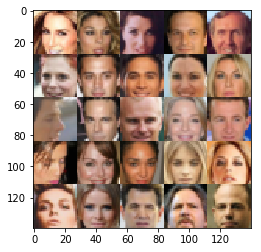

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [290]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input_images')
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])
    learn_rate = tf.placeholder(tf.float32)
    return (real_input_images, z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [291]:
def convolve(prev_layer, filter_output_count, kernel_size, strides=[2, 2], leaky_relu_alpha=.2, training=True):
    # Transposed / Inverted convolution / deconvolution + batch norm + leaky relu
    x = tf.layers.conv2d(prev_layer, filter_output_count, kernel_size, strides, padding='same')
    x = tf.layers.batch_normalization(x, training=training) #batch norm is here
    x = tf.maximum(x * leaky_relu_alpha, x) # leaky part of relu is implemented here.
    x = tf.nn.dropout(x, keep_prob=.9)
    return x

In [311]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None) #, kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))  #14 x 14
        x = tf.maximum(alpha * x, x)

        x = convolve(x, 128, 5, strides=2, leaky_relu_alpha=alpha, training=True) # 7 x 7
        x = convolve(x, 256, 5, strides=2, leaky_relu_alpha=alpha, training=True) # 4 x 4
        #x = convolve(x, 512, 3, strides=2, leaky_relu_alpha=alpha, training=True) # 4 x 4

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        #x = tf.layers.dropout(x, rate=.3, training=training)
        out = tf.sigmoid(logits)
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [294]:
def deconvolve(x, output_layer_count, kernel_size, strides=2, alpha=.2, training=True):
    x = tf.layers.conv2d_transpose(x, output_layer_count, kernel_size=kernel_size, strides=strides, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.05))
    x = tf.layers.batch_normalization(x, training=training)
    x = tf.maximum(x*alpha, x)
    return x

In [312]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #you can have 4 (2), 8 (2), 16 (4), 24 (6), 28
    #print(z)
    alpha=.2
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))  # 7 x 7
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        x = deconvolve(x, 256, 5, strides=2, alpha=alpha, training=is_train)  # 14 x 14
        x = tf.nn.dropout(x, keep_prob=.9)
        x = deconvolve(x, 128, 5, strides=2, alpha=alpha, training=is_train)  # 14 x 14
        x = tf.nn.dropout(x, keep_prob=.9)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))  # 28 x 28
        #x = tf.layers.conv2d_transpose(x, out_channel_dim, 1, strides=1, padding='same')
        x = tf.tanh(x)
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [296]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)  #, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real)  #, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)  #, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * .9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [297]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    # Optimize
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #with tf.control_dependencies(g_updates):
        #g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [298]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [307]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    print_interval = 10
    show_interval = 100
    # Create placeholders
    w = data_shape[1]
    h = data_shape[2]

    if data_image_mode == 'RGB':
        image_channels = 3
    else:
        image_channels = 1

    real_input_images, z_input, learn_rate = model_inputs(w, h, data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    is_train = tf.placeholder(tf.bool)
    train_loss_d, train_loss_g = 0.0, 0.0
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                steps += 1
                batch_images *= 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_images: batch_images, z_input: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input_images: batch_images, z_input: batch_z, learn_rate:learning_rate, is_train: True})
                if steps % print_interval == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input_images: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z, is_train: False})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.7f}...".format(train_loss_d),
                          "Generator Loss: {:.7f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_interval == 0:
                    show_generator_output(sess, 36, z_input, data_shape[3], data_image_mode)

    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2883322... Generator Loss: 0.6399584
Epoch 1/2... Discriminator Loss: 1.4583809... Generator Loss: 0.6248668
Epoch 1/2... Discriminator Loss: 1.1320691... Generator Loss: 1.3444986
Epoch 1/2... Discriminator Loss: 1.4803042... Generator Loss: 0.4943653
Epoch 1/2... Discriminator Loss: 1.3214688... Generator Loss: 0.6328236
Epoch 1/2... Discriminator Loss: 1.3803139... Generator Loss: 0.5554857
Epoch 1/2... Discriminator Loss: 1.5610352... Generator Loss: 0.6304588
Epoch 1/2... Discriminator Loss: 1.3161464... Generator Loss: 0.8640167
Epoch 1/2... Discriminator Loss: 1.3576384... Generator Loss: 0.6524991
Epoch 1/2... Discriminator Loss: 1.3065623... Generator Loss: 0.7910304


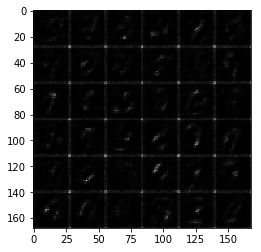

Epoch 1/2... Discriminator Loss: 1.3096519... Generator Loss: 0.8487095
Epoch 1/2... Discriminator Loss: 1.3073368... Generator Loss: 0.9383575
Epoch 1/2... Discriminator Loss: 1.2506738... Generator Loss: 0.7843076
Epoch 1/2... Discriminator Loss: 1.2964296... Generator Loss: 0.6349611
Epoch 1/2... Discriminator Loss: 1.4023464... Generator Loss: 0.5725682
Epoch 1/2... Discriminator Loss: 1.3178134... Generator Loss: 0.5835967
Epoch 1/2... Discriminator Loss: 1.1982442... Generator Loss: 1.4261740
Epoch 1/2... Discriminator Loss: 1.3315041... Generator Loss: 1.4405148
Epoch 1/2... Discriminator Loss: 1.1605399... Generator Loss: 0.8612799
Epoch 1/2... Discriminator Loss: 1.1613729... Generator Loss: 0.7447433


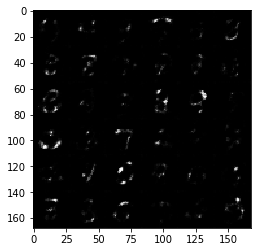

Epoch 1/2... Discriminator Loss: 1.0331409... Generator Loss: 1.6410527
Epoch 1/2... Discriminator Loss: 1.1078740... Generator Loss: 1.0551395
Epoch 1/2... Discriminator Loss: 1.5923269... Generator Loss: 0.4437732
Epoch 1/2... Discriminator Loss: 1.1024092... Generator Loss: 0.7501667
Epoch 1/2... Discriminator Loss: 0.8436936... Generator Loss: 1.3446608
Epoch 1/2... Discriminator Loss: 0.9850501... Generator Loss: 1.1728994
Epoch 1/2... Discriminator Loss: 0.9191900... Generator Loss: 1.3127365
Epoch 1/2... Discriminator Loss: 1.2816215... Generator Loss: 0.5925893
Epoch 1/2... Discriminator Loss: 1.0545394... Generator Loss: 0.9872139
Epoch 1/2... Discriminator Loss: 0.8924736... Generator Loss: 1.2539722


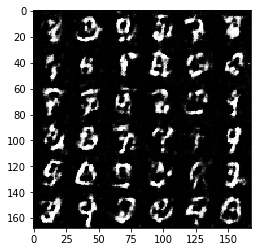

Epoch 1/2... Discriminator Loss: 0.9130341... Generator Loss: 1.2083452
Epoch 1/2... Discriminator Loss: 1.0281907... Generator Loss: 1.5958531
Epoch 1/2... Discriminator Loss: 0.8393975... Generator Loss: 1.3667076
Epoch 1/2... Discriminator Loss: 1.1417711... Generator Loss: 0.7498689
Epoch 1/2... Discriminator Loss: 0.8418268... Generator Loss: 1.2407154
Epoch 1/2... Discriminator Loss: 0.7636061... Generator Loss: 1.5602978
Epoch 1/2... Discriminator Loss: 0.7882726... Generator Loss: 1.5119188
Epoch 1/2... Discriminator Loss: 0.7937329... Generator Loss: 1.2190607
Epoch 1/2... Discriminator Loss: 1.0268483... Generator Loss: 1.2407553
Epoch 1/2... Discriminator Loss: 0.8408070... Generator Loss: 1.3169456


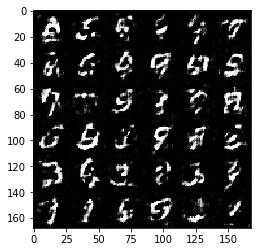

Epoch 1/2... Discriminator Loss: 0.8158948... Generator Loss: 1.9568162
Epoch 1/2... Discriminator Loss: 0.7025754... Generator Loss: 1.8293049
Epoch 1/2... Discriminator Loss: 1.1290228... Generator Loss: 2.4768262
Epoch 1/2... Discriminator Loss: 0.8142003... Generator Loss: 1.2878044
Epoch 1/2... Discriminator Loss: 0.6944371... Generator Loss: 1.5224833
Epoch 1/2... Discriminator Loss: 0.7520322... Generator Loss: 1.4289700
Epoch 1/2... Discriminator Loss: 0.8288316... Generator Loss: 1.5536592
Epoch 1/2... Discriminator Loss: 0.7752888... Generator Loss: 1.5559288
Epoch 1/2... Discriminator Loss: 1.1618750... Generator Loss: 0.8148845
Epoch 1/2... Discriminator Loss: 1.2190256... Generator Loss: 0.7511595


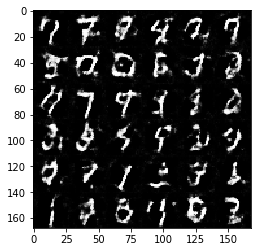

Epoch 1/2... Discriminator Loss: 1.4140894... Generator Loss: 0.5542159
Epoch 1/2... Discriminator Loss: 1.1352918... Generator Loss: 0.8937750
Epoch 1/2... Discriminator Loss: 1.1563280... Generator Loss: 1.2859577
Epoch 1/2... Discriminator Loss: 1.0006754... Generator Loss: 0.8416430
Epoch 1/2... Discriminator Loss: 1.1599864... Generator Loss: 1.6908246
Epoch 1/2... Discriminator Loss: 1.1855016... Generator Loss: 0.7596102
Epoch 1/2... Discriminator Loss: 1.6122049... Generator Loss: 0.5016520
Epoch 1/2... Discriminator Loss: 1.0137347... Generator Loss: 1.0799623
Epoch 1/2... Discriminator Loss: 1.1400564... Generator Loss: 0.9265554
Epoch 1/2... Discriminator Loss: 1.2289741... Generator Loss: 1.5634466


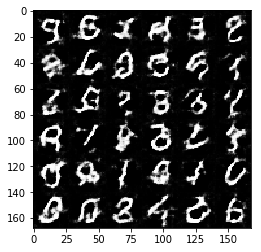

Epoch 1/2... Discriminator Loss: 1.0818361... Generator Loss: 1.2910608
Epoch 1/2... Discriminator Loss: 1.1614954... Generator Loss: 1.6946828
Epoch 1/2... Discriminator Loss: 1.1178916... Generator Loss: 1.1039845
Epoch 1/2... Discriminator Loss: 1.0474887... Generator Loss: 1.0343550
Epoch 1/2... Discriminator Loss: 1.2473235... Generator Loss: 0.9508591
Epoch 1/2... Discriminator Loss: 1.0559707... Generator Loss: 0.8856412
Epoch 1/2... Discriminator Loss: 1.0905819... Generator Loss: 1.4573421
Epoch 1/2... Discriminator Loss: 1.3140326... Generator Loss: 1.0603391
Epoch 1/2... Discriminator Loss: 1.0515105... Generator Loss: 0.9420198
Epoch 1/2... Discriminator Loss: 1.0126381... Generator Loss: 1.3791635


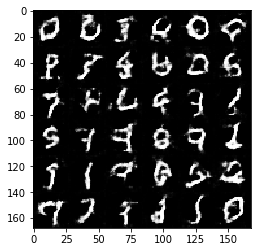

Epoch 1/2... Discriminator Loss: 1.3910716... Generator Loss: 0.5851109
Epoch 1/2... Discriminator Loss: 1.1767908... Generator Loss: 0.7864983
Epoch 1/2... Discriminator Loss: 1.0839200... Generator Loss: 1.4363983
Epoch 1/2... Discriminator Loss: 0.9541918... Generator Loss: 1.2755513
Epoch 1/2... Discriminator Loss: 1.1566296... Generator Loss: 0.8454792
Epoch 1/2... Discriminator Loss: 1.1943412... Generator Loss: 0.6713706
Epoch 1/2... Discriminator Loss: 1.0236678... Generator Loss: 1.0374572
Epoch 1/2... Discriminator Loss: 1.0762173... Generator Loss: 1.0183389
Epoch 1/2... Discriminator Loss: 1.2163706... Generator Loss: 0.7244629
Epoch 1/2... Discriminator Loss: 1.1564217... Generator Loss: 1.8134559


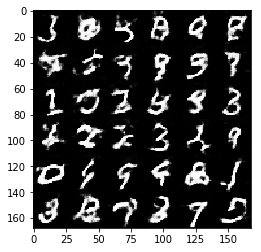

Epoch 1/2... Discriminator Loss: 1.0719292... Generator Loss: 1.7210472
Epoch 1/2... Discriminator Loss: 1.1226376... Generator Loss: 1.7581443
Epoch 1/2... Discriminator Loss: 1.0714556... Generator Loss: 0.8369635
Epoch 1/2... Discriminator Loss: 0.8770426... Generator Loss: 1.2836730
Epoch 1/2... Discriminator Loss: 1.0137217... Generator Loss: 1.0563524
Epoch 1/2... Discriminator Loss: 2.9725895... Generator Loss: 0.1471039
Epoch 1/2... Discriminator Loss: 1.2818472... Generator Loss: 1.1269231
Epoch 1/2... Discriminator Loss: 1.0039811... Generator Loss: 1.1839662
Epoch 1/2... Discriminator Loss: 0.9778578... Generator Loss: 1.0691864
Epoch 1/2... Discriminator Loss: 1.1550291... Generator Loss: 0.9046764


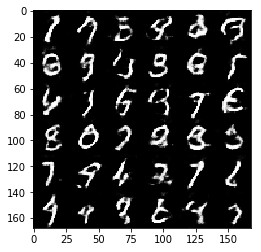

Epoch 1/2... Discriminator Loss: 1.1007719... Generator Loss: 0.7542077
Epoch 1/2... Discriminator Loss: 0.8782738... Generator Loss: 1.3820889
Epoch 1/2... Discriminator Loss: 1.0895455... Generator Loss: 0.9940578
Epoch 2/2... Discriminator Loss: 1.3424678... Generator Loss: 0.5761933
Epoch 2/2... Discriminator Loss: 0.9107445... Generator Loss: 1.5022825
Epoch 2/2... Discriminator Loss: 1.0359516... Generator Loss: 1.2277255
Epoch 2/2... Discriminator Loss: 1.1007874... Generator Loss: 1.2748504
Epoch 2/2... Discriminator Loss: 1.1114511... Generator Loss: 0.8103238
Epoch 2/2... Discriminator Loss: 1.2295632... Generator Loss: 0.6298819
Epoch 2/2... Discriminator Loss: 1.1861790... Generator Loss: 1.7029932


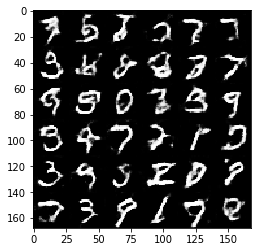

Epoch 2/2... Discriminator Loss: 1.0575664... Generator Loss: 1.2377124
Epoch 2/2... Discriminator Loss: 1.0850925... Generator Loss: 0.9704071
Epoch 2/2... Discriminator Loss: 0.9690062... Generator Loss: 1.2422953
Epoch 2/2... Discriminator Loss: 1.0666542... Generator Loss: 1.1150823
Epoch 2/2... Discriminator Loss: 0.9985976... Generator Loss: 1.0564785
Epoch 2/2... Discriminator Loss: 1.1083169... Generator Loss: 0.8741405
Epoch 2/2... Discriminator Loss: 1.1930720... Generator Loss: 0.7936544
Epoch 2/2... Discriminator Loss: 0.9539058... Generator Loss: 1.3643252
Epoch 2/2... Discriminator Loss: 1.0411863... Generator Loss: 1.0254598
Epoch 2/2... Discriminator Loss: 0.9753671... Generator Loss: 1.4055691


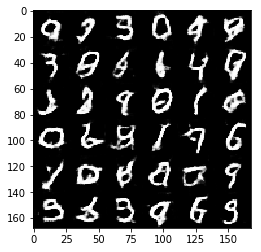

Epoch 2/2... Discriminator Loss: 1.0243554... Generator Loss: 0.9722115
Epoch 2/2... Discriminator Loss: 0.9238852... Generator Loss: 1.7343934
Epoch 2/2... Discriminator Loss: 0.9148382... Generator Loss: 1.3168021
Epoch 2/2... Discriminator Loss: 0.9236177... Generator Loss: 1.4300082
Epoch 2/2... Discriminator Loss: 0.9419329... Generator Loss: 1.1178691
Epoch 2/2... Discriminator Loss: 0.9773677... Generator Loss: 1.5670586
Epoch 2/2... Discriminator Loss: 1.3887432... Generator Loss: 1.6959453
Epoch 2/2... Discriminator Loss: 1.0215311... Generator Loss: 1.0780373
Epoch 2/2... Discriminator Loss: 0.9930261... Generator Loss: 1.0956590
Epoch 2/2... Discriminator Loss: 0.8324536... Generator Loss: 1.5337930


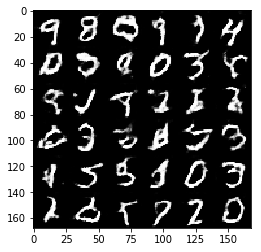

Epoch 2/2... Discriminator Loss: 1.0908859... Generator Loss: 1.0050392
Epoch 2/2... Discriminator Loss: 0.9798272... Generator Loss: 1.2995405
Epoch 2/2... Discriminator Loss: 0.9385637... Generator Loss: 1.3343636
Epoch 2/2... Discriminator Loss: 1.2963611... Generator Loss: 0.6800302
Epoch 2/2... Discriminator Loss: 0.8632079... Generator Loss: 1.5458891
Epoch 2/2... Discriminator Loss: 1.0702074... Generator Loss: 0.8983501
Epoch 2/2... Discriminator Loss: 1.0961783... Generator Loss: 0.8868767
Epoch 2/2... Discriminator Loss: 0.9979503... Generator Loss: 0.9331143
Epoch 2/2... Discriminator Loss: 0.9760010... Generator Loss: 1.1739192
Epoch 2/2... Discriminator Loss: 0.9944016... Generator Loss: 1.0554063


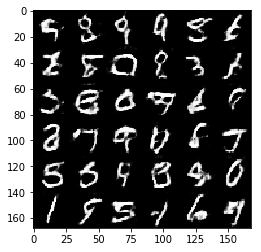

Epoch 2/2... Discriminator Loss: 0.9841627... Generator Loss: 1.3363681
Epoch 2/2... Discriminator Loss: 0.9273970... Generator Loss: 1.3997247
Epoch 2/2... Discriminator Loss: 0.8130820... Generator Loss: 1.8941228
Epoch 2/2... Discriminator Loss: 1.1050917... Generator Loss: 0.7367995
Epoch 2/2... Discriminator Loss: 1.2002296... Generator Loss: 0.8721400
Epoch 2/2... Discriminator Loss: 1.1688247... Generator Loss: 0.6724612
Epoch 2/2... Discriminator Loss: 0.9058673... Generator Loss: 1.4020846
Epoch 2/2... Discriminator Loss: 0.8708062... Generator Loss: 1.8586495
Epoch 2/2... Discriminator Loss: 1.1147258... Generator Loss: 2.2885222
Epoch 2/2... Discriminator Loss: 1.3397253... Generator Loss: 1.5568874


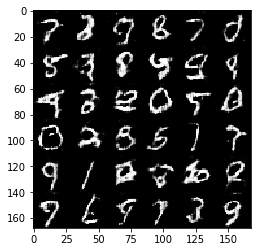

Epoch 2/2... Discriminator Loss: 0.8247242... Generator Loss: 1.4502165
Epoch 2/2... Discriminator Loss: 1.0441146... Generator Loss: 1.1697267
Epoch 2/2... Discriminator Loss: 0.9181553... Generator Loss: 1.1639500
Epoch 2/2... Discriminator Loss: 0.8566213... Generator Loss: 1.3018147
Epoch 2/2... Discriminator Loss: 1.0168248... Generator Loss: 0.8598142
Epoch 2/2... Discriminator Loss: 1.1842824... Generator Loss: 1.8645406
Epoch 2/2... Discriminator Loss: 1.0119033... Generator Loss: 1.0249505
Epoch 2/2... Discriminator Loss: 0.9051543... Generator Loss: 1.4056356
Epoch 2/2... Discriminator Loss: 0.9346620... Generator Loss: 1.1337425
Epoch 2/2... Discriminator Loss: 0.8330388... Generator Loss: 1.9732220


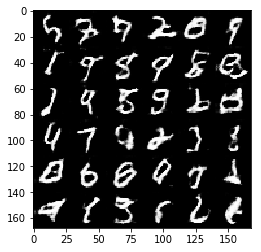

Epoch 2/2... Discriminator Loss: 0.8187011... Generator Loss: 1.6400290
Epoch 2/2... Discriminator Loss: 0.9155709... Generator Loss: 1.1465843
Epoch 2/2... Discriminator Loss: 0.8513214... Generator Loss: 1.2706941
Epoch 2/2... Discriminator Loss: 0.8393461... Generator Loss: 1.4845861
Epoch 2/2... Discriminator Loss: 0.8538846... Generator Loss: 1.1456544
Epoch 2/2... Discriminator Loss: 0.8785642... Generator Loss: 1.7193921
Epoch 2/2... Discriminator Loss: 1.0899160... Generator Loss: 0.8981592
Epoch 2/2... Discriminator Loss: 0.8772302... Generator Loss: 1.1533846
Epoch 2/2... Discriminator Loss: 2.0581417... Generator Loss: 2.4462183
Epoch 2/2... Discriminator Loss: 1.2943075... Generator Loss: 1.1048110


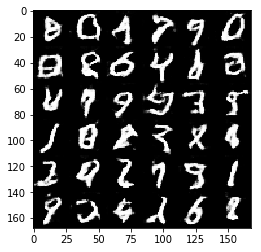

Epoch 2/2... Discriminator Loss: 1.2359916... Generator Loss: 0.7856064
Epoch 2/2... Discriminator Loss: 1.0193592... Generator Loss: 1.1158092
Epoch 2/2... Discriminator Loss: 1.0986892... Generator Loss: 1.0294240
Epoch 2/2... Discriminator Loss: 0.9715310... Generator Loss: 1.2846475
Epoch 2/2... Discriminator Loss: 0.8218653... Generator Loss: 1.7271869
Epoch 2/2... Discriminator Loss: 0.9163213... Generator Loss: 1.8917072
Epoch 2/2... Discriminator Loss: 0.7552188... Generator Loss: 1.3177032
Epoch 2/2... Discriminator Loss: 0.7741444... Generator Loss: 1.8613898
Epoch 2/2... Discriminator Loss: 0.8298360... Generator Loss: 1.4432740
Epoch 2/2... Discriminator Loss: 1.0245738... Generator Loss: 0.9897110


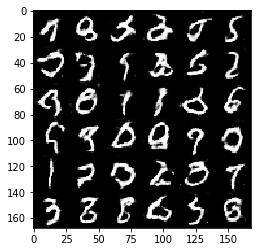

Epoch 2/2... Discriminator Loss: 0.9744171... Generator Loss: 1.2474879
Epoch 2/2... Discriminator Loss: 1.1577704... Generator Loss: 0.7167202
Epoch 2/2... Discriminator Loss: 1.2997469... Generator Loss: 0.6629173
Epoch 2/2... Discriminator Loss: 1.2014263... Generator Loss: 1.0632966
Epoch 2/2... Discriminator Loss: 0.8507761... Generator Loss: 1.4388032
Epoch 2/2... Discriminator Loss: 0.7927213... Generator Loss: 1.7328826
Epoch 2/2... Discriminator Loss: 0.8978317... Generator Loss: 1.3574597
Epoch 2/2... Discriminator Loss: 0.8201956... Generator Loss: 1.3767806
Epoch 2/2... Discriminator Loss: 0.6800011... Generator Loss: 1.7337627
Epoch 2/2... Discriminator Loss: 1.2378825... Generator Loss: 0.8633260


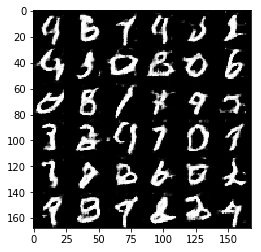

Epoch 2/2... Discriminator Loss: 0.9353596... Generator Loss: 1.2032566
Epoch 2/2... Discriminator Loss: 1.2780910... Generator Loss: 0.6366497
Epoch 2/2... Discriminator Loss: 0.9464512... Generator Loss: 1.5787581
Epoch 2/2... Discriminator Loss: 0.9611959... Generator Loss: 1.3150954
Epoch 2/2... Discriminator Loss: 1.0409601... Generator Loss: 1.8544238
Epoch 2/2... Discriminator Loss: 1.0803833... Generator Loss: 1.8825293
Epoch 2/2... Discriminator Loss: 0.7728497... Generator Loss: 1.5194736


In [308]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

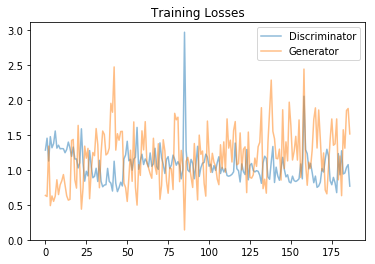

In [309]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7924478... Generator Loss: 1.3869225
Epoch 1/1... Discriminator Loss: 0.5367361... Generator Loss: 2.2787895
Epoch 1/1... Discriminator Loss: 0.6869642... Generator Loss: 1.7912034
Epoch 1/1... Discriminator Loss: 0.4079640... Generator Loss: 3.6604609
Epoch 1/1... Discriminator Loss: 0.5080837... Generator Loss: 3.1175923
Epoch 1/1... Discriminator Loss: 0.6823305... Generator Loss: 1.7036288
Epoch 1/1... Discriminator Loss: 0.5240275... Generator Loss: 2.4732819
Epoch 1/1... Discriminator Loss: 0.5043799... Generator Loss: 2.6582503
Epoch 1/1... Discriminator Loss: 1.0004954... Generator Loss: 5.7795987
Epoch 1/1... Discriminator Loss: 0.5389285... Generator Loss: 2.2387857


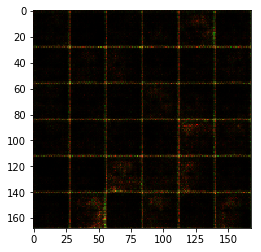

Epoch 1/1... Discriminator Loss: 0.4920801... Generator Loss: 2.6219587
Epoch 1/1... Discriminator Loss: 0.3864286... Generator Loss: 3.8273158
Epoch 1/1... Discriminator Loss: 0.3925511... Generator Loss: 5.3071141
Epoch 1/1... Discriminator Loss: 0.7580391... Generator Loss: 1.7634821
Epoch 1/1... Discriminator Loss: 0.8751011... Generator Loss: 1.3584201
Epoch 1/1... Discriminator Loss: 0.3935377... Generator Loss: 3.6397250
Epoch 1/1... Discriminator Loss: 0.3926235... Generator Loss: 3.4762096
Epoch 1/1... Discriminator Loss: 0.4274515... Generator Loss: 3.2396011
Epoch 1/1... Discriminator Loss: 0.5014485... Generator Loss: 6.4590588
Epoch 1/1... Discriminator Loss: 0.3738590... Generator Loss: 4.6893759


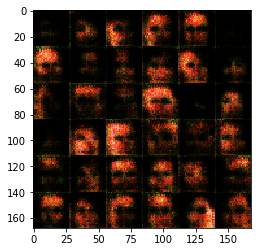

Epoch 1/1... Discriminator Loss: 0.3630038... Generator Loss: 5.1022754
Epoch 1/1... Discriminator Loss: 0.5408181... Generator Loss: 2.4969993
Epoch 1/1... Discriminator Loss: 0.3861994... Generator Loss: 4.2531648
Epoch 1/1... Discriminator Loss: 0.3760934... Generator Loss: 4.3542914
Epoch 1/1... Discriminator Loss: 0.3857136... Generator Loss: 3.6110501
Epoch 1/1... Discriminator Loss: 0.3666750... Generator Loss: 4.3161144
Epoch 1/1... Discriminator Loss: 0.3924944... Generator Loss: 3.6668096
Epoch 1/1... Discriminator Loss: 0.4379011... Generator Loss: 3.0886507
Epoch 1/1... Discriminator Loss: 0.6101640... Generator Loss: 2.0006187
Epoch 1/1... Discriminator Loss: 0.5424072... Generator Loss: 2.4085393


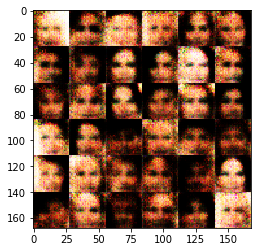

Epoch 1/1... Discriminator Loss: 0.5361710... Generator Loss: 2.4080021
Epoch 1/1... Discriminator Loss: 0.4616503... Generator Loss: 3.4672039
Epoch 1/1... Discriminator Loss: 0.4214121... Generator Loss: 3.0902081
Epoch 1/1... Discriminator Loss: 0.4174374... Generator Loss: 3.4827676
Epoch 1/1... Discriminator Loss: 0.6732039... Generator Loss: 1.7077402
Epoch 1/1... Discriminator Loss: 0.4450670... Generator Loss: 2.7530127
Epoch 1/1... Discriminator Loss: 0.3850309... Generator Loss: 4.0464354
Epoch 1/1... Discriminator Loss: 0.4001279... Generator Loss: 3.3465297
Epoch 1/1... Discriminator Loss: 0.4614228... Generator Loss: 3.1636550
Epoch 1/1... Discriminator Loss: 0.5968211... Generator Loss: 2.2000921


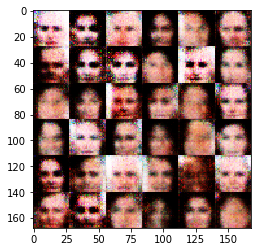

Epoch 1/1... Discriminator Loss: 0.5397642... Generator Loss: 3.2100794
Epoch 1/1... Discriminator Loss: 0.5211774... Generator Loss: 2.3766656
Epoch 1/1... Discriminator Loss: 1.0777566... Generator Loss: 0.9092666
Epoch 1/1... Discriminator Loss: 0.5812842... Generator Loss: 3.5828013
Epoch 1/1... Discriminator Loss: 0.5967319... Generator Loss: 2.0534141
Epoch 1/1... Discriminator Loss: 0.6064624... Generator Loss: 3.5888014
Epoch 1/1... Discriminator Loss: 1.4313599... Generator Loss: 0.5597979
Epoch 1/1... Discriminator Loss: 0.5770604... Generator Loss: 2.7200983
Epoch 1/1... Discriminator Loss: 0.5924322... Generator Loss: 2.8366446
Epoch 1/1... Discriminator Loss: 0.7890596... Generator Loss: 1.4041197


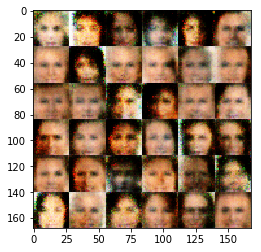

Epoch 1/1... Discriminator Loss: 0.5644638... Generator Loss: 2.0041075
Epoch 1/1... Discriminator Loss: 0.7446651... Generator Loss: 1.5367492
Epoch 1/1... Discriminator Loss: 2.0545099... Generator Loss: 4.0403857
Epoch 1/1... Discriminator Loss: 0.7425918... Generator Loss: 3.1246548
Epoch 1/1... Discriminator Loss: 0.6231458... Generator Loss: 1.8604558
Epoch 1/1... Discriminator Loss: 0.7158069... Generator Loss: 1.7234626
Epoch 1/1... Discriminator Loss: 0.7600846... Generator Loss: 2.7490211
Epoch 1/1... Discriminator Loss: 0.5767001... Generator Loss: 2.2311487
Epoch 1/1... Discriminator Loss: 0.6525379... Generator Loss: 2.2362280
Epoch 1/1... Discriminator Loss: 1.5098554... Generator Loss: 2.9951241


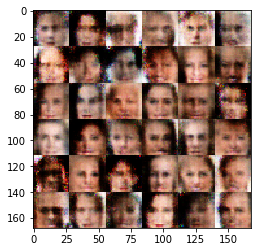

Epoch 1/1... Discriminator Loss: 0.7037315... Generator Loss: 2.0899706
Epoch 1/1... Discriminator Loss: 0.5944192... Generator Loss: 2.3378668
Epoch 1/1... Discriminator Loss: 0.9419614... Generator Loss: 3.0745237
Epoch 1/1... Discriminator Loss: 0.9630848... Generator Loss: 0.9865805
Epoch 1/1... Discriminator Loss: 0.6876734... Generator Loss: 1.5879445
Epoch 1/1... Discriminator Loss: 1.2366667... Generator Loss: 0.7463857
Epoch 1/1... Discriminator Loss: 0.7789804... Generator Loss: 1.3783665
Epoch 1/1... Discriminator Loss: 0.8213128... Generator Loss: 1.9355694
Epoch 1/1... Discriminator Loss: 0.9315292... Generator Loss: 1.1512136
Epoch 1/1... Discriminator Loss: 0.8090643... Generator Loss: 2.6298518


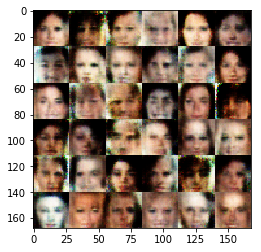

Epoch 1/1... Discriminator Loss: 0.9910371... Generator Loss: 2.4581752
Epoch 1/1... Discriminator Loss: 0.9645615... Generator Loss: 3.4067056
Epoch 1/1... Discriminator Loss: 0.7920095... Generator Loss: 2.0050402
Epoch 1/1... Discriminator Loss: 0.7817214... Generator Loss: 1.2841599
Epoch 1/1... Discriminator Loss: 0.6418995... Generator Loss: 2.0648489
Epoch 1/1... Discriminator Loss: 0.5908907... Generator Loss: 2.1459386
Epoch 1/1... Discriminator Loss: 0.8191221... Generator Loss: 1.7075778
Epoch 1/1... Discriminator Loss: 0.7942857... Generator Loss: 2.1421366
Epoch 1/1... Discriminator Loss: 0.8566911... Generator Loss: 2.5304747
Epoch 1/1... Discriminator Loss: 0.8052516... Generator Loss: 1.5494499


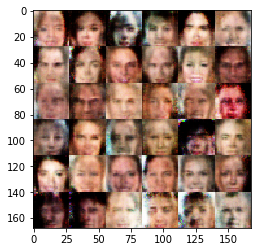

Epoch 1/1... Discriminator Loss: 0.8418564... Generator Loss: 1.4421786
Epoch 1/1... Discriminator Loss: 0.8707554... Generator Loss: 1.1171505
Epoch 1/1... Discriminator Loss: 0.9680070... Generator Loss: 1.0063195
Epoch 1/1... Discriminator Loss: 0.8025367... Generator Loss: 1.4020100
Epoch 1/1... Discriminator Loss: 0.8462787... Generator Loss: 1.4922276
Epoch 1/1... Discriminator Loss: 0.9333541... Generator Loss: 1.0695386
Epoch 1/1... Discriminator Loss: 1.0710924... Generator Loss: 3.2121522
Epoch 1/1... Discriminator Loss: 1.3160511... Generator Loss: 0.5896925
Epoch 1/1... Discriminator Loss: 1.2337337... Generator Loss: 2.7293444
Epoch 1/1... Discriminator Loss: 1.1787267... Generator Loss: 0.6727777


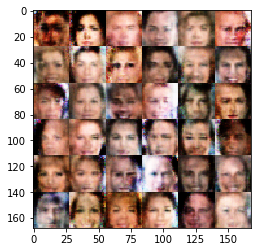

Epoch 1/1... Discriminator Loss: 0.7333062... Generator Loss: 2.3701472
Epoch 1/1... Discriminator Loss: 0.9189049... Generator Loss: 1.7955892
Epoch 1/1... Discriminator Loss: 1.1527531... Generator Loss: 3.1154213
Epoch 1/1... Discriminator Loss: 0.8770628... Generator Loss: 1.9543819
Epoch 1/1... Discriminator Loss: 0.7606349... Generator Loss: 1.5891562
Epoch 1/1... Discriminator Loss: 0.9300044... Generator Loss: 1.1615567
Epoch 1/1... Discriminator Loss: 1.0618500... Generator Loss: 0.8351396
Epoch 1/1... Discriminator Loss: 0.8217275... Generator Loss: 1.2786477
Epoch 1/1... Discriminator Loss: 0.9442083... Generator Loss: 1.4164977
Epoch 1/1... Discriminator Loss: 0.8195593... Generator Loss: 1.3104110


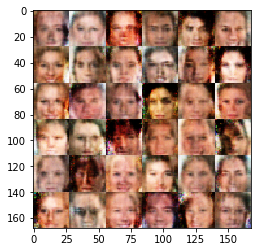

Epoch 1/1... Discriminator Loss: 0.8201100... Generator Loss: 1.4676552
Epoch 1/1... Discriminator Loss: 0.9436969... Generator Loss: 0.9873071
Epoch 1/1... Discriminator Loss: 0.9852196... Generator Loss: 0.8885469
Epoch 1/1... Discriminator Loss: 0.9476973... Generator Loss: 1.1072836
Epoch 1/1... Discriminator Loss: 0.9682363... Generator Loss: 1.2285236
Epoch 1/1... Discriminator Loss: 1.2567388... Generator Loss: 0.6480102
Epoch 1/1... Discriminator Loss: 0.9976064... Generator Loss: 1.9767064
Epoch 1/1... Discriminator Loss: 1.0720855... Generator Loss: 2.2292414
Epoch 1/1... Discriminator Loss: 1.6395057... Generator Loss: 0.4434497
Epoch 1/1... Discriminator Loss: 0.9843905... Generator Loss: 1.0856695


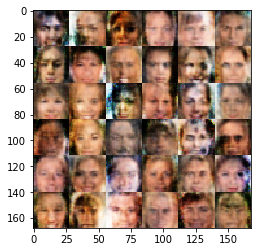

Epoch 1/1... Discriminator Loss: 0.9162676... Generator Loss: 1.3039794
Epoch 1/1... Discriminator Loss: 0.9170005... Generator Loss: 1.6950469
Epoch 1/1... Discriminator Loss: 0.9105799... Generator Loss: 1.1667109
Epoch 1/1... Discriminator Loss: 0.8272723... Generator Loss: 1.2517482
Epoch 1/1... Discriminator Loss: 1.2414517... Generator Loss: 2.7453623
Epoch 1/1... Discriminator Loss: 0.8576751... Generator Loss: 1.8829290
Epoch 1/1... Discriminator Loss: 0.8435518... Generator Loss: 1.4425012
Epoch 1/1... Discriminator Loss: 0.8798962... Generator Loss: 1.5498635
Epoch 1/1... Discriminator Loss: 1.1211195... Generator Loss: 1.9080962
Epoch 1/1... Discriminator Loss: 0.9933811... Generator Loss: 1.3158656


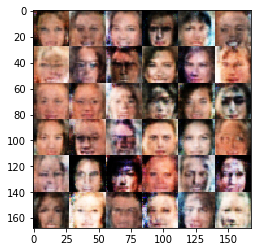

Epoch 1/1... Discriminator Loss: 0.8520843... Generator Loss: 1.2507856
Epoch 1/1... Discriminator Loss: 0.9305936... Generator Loss: 1.4157519
Epoch 1/1... Discriminator Loss: 1.1482182... Generator Loss: 0.7904581
Epoch 1/1... Discriminator Loss: 0.9672735... Generator Loss: 1.5003293
Epoch 1/1... Discriminator Loss: 1.0432582... Generator Loss: 1.0147507
Epoch 1/1... Discriminator Loss: 0.9014444... Generator Loss: 1.1179650
Epoch 1/1... Discriminator Loss: 1.0630832... Generator Loss: 1.7649164
Epoch 1/1... Discriminator Loss: 1.1245430... Generator Loss: 0.8356900
Epoch 1/1... Discriminator Loss: 0.9506445... Generator Loss: 1.5201511
Epoch 1/1... Discriminator Loss: 1.1213874... Generator Loss: 1.3444057


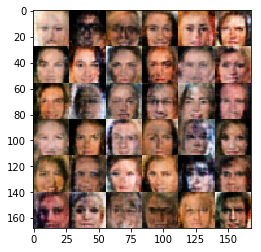

Epoch 1/1... Discriminator Loss: 1.6642784... Generator Loss: 0.3837922
Epoch 1/1... Discriminator Loss: 0.9706848... Generator Loss: 1.3455788
Epoch 1/1... Discriminator Loss: 0.8361490... Generator Loss: 1.2612982
Epoch 1/1... Discriminator Loss: 0.7651331... Generator Loss: 2.5585036
Epoch 1/1... Discriminator Loss: 1.2127125... Generator Loss: 0.7106116
Epoch 1/1... Discriminator Loss: 0.8391134... Generator Loss: 1.7528974
Epoch 1/1... Discriminator Loss: 0.9487908... Generator Loss: 1.0231694
Epoch 1/1... Discriminator Loss: 0.9689051... Generator Loss: 1.6487423
Epoch 1/1... Discriminator Loss: 0.9708368... Generator Loss: 1.4919521
Epoch 1/1... Discriminator Loss: 1.3362188... Generator Loss: 0.6706581


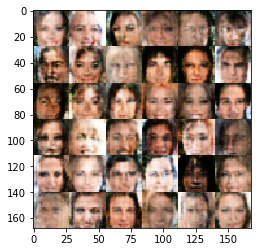

Epoch 1/1... Discriminator Loss: 0.8825940... Generator Loss: 1.2629218
Epoch 1/1... Discriminator Loss: 1.2169030... Generator Loss: 0.7864802
Epoch 1/1... Discriminator Loss: 1.0485313... Generator Loss: 1.0628676
Epoch 1/1... Discriminator Loss: 1.2002683... Generator Loss: 0.7201029
Epoch 1/1... Discriminator Loss: 1.1727890... Generator Loss: 1.1144943
Epoch 1/1... Discriminator Loss: 1.5793896... Generator Loss: 0.5284189
Epoch 1/1... Discriminator Loss: 1.3443426... Generator Loss: 0.5795344
Epoch 1/1... Discriminator Loss: 1.1428947... Generator Loss: 0.7507789
Epoch 1/1... Discriminator Loss: 0.8963989... Generator Loss: 1.5227523
Epoch 1/1... Discriminator Loss: 1.5844902... Generator Loss: 0.4318978


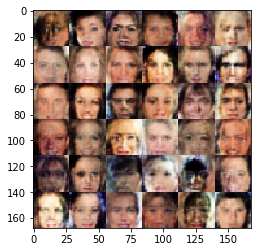

Epoch 1/1... Discriminator Loss: 1.4846709... Generator Loss: 0.7991180
Epoch 1/1... Discriminator Loss: 1.3024588... Generator Loss: 0.8256845
Epoch 1/1... Discriminator Loss: 0.9272400... Generator Loss: 1.1730736
Epoch 1/1... Discriminator Loss: 0.9239373... Generator Loss: 1.6862285
Epoch 1/1... Discriminator Loss: 0.9406235... Generator Loss: 1.7768784
Epoch 1/1... Discriminator Loss: 1.1774693... Generator Loss: 0.6479754
Epoch 1/1... Discriminator Loss: 1.1517313... Generator Loss: 0.8557378
Epoch 1/1... Discriminator Loss: 1.0571216... Generator Loss: 1.0389028
Epoch 1/1... Discriminator Loss: 1.0741295... Generator Loss: 0.9573271
Epoch 1/1... Discriminator Loss: 1.0561838... Generator Loss: 1.0527434


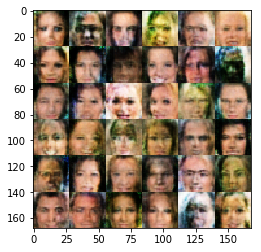

Epoch 1/1... Discriminator Loss: 1.0563619... Generator Loss: 1.1418837
Epoch 1/1... Discriminator Loss: 1.1229903... Generator Loss: 0.8599619
Epoch 1/1... Discriminator Loss: 1.2938926... Generator Loss: 0.7351800
Epoch 1/1... Discriminator Loss: 1.0542746... Generator Loss: 1.0016665
Epoch 1/1... Discriminator Loss: 0.8868378... Generator Loss: 1.0883129
Epoch 1/1... Discriminator Loss: 1.0325785... Generator Loss: 0.9438227
Epoch 1/1... Discriminator Loss: 1.4364508... Generator Loss: 0.5884236
Epoch 1/1... Discriminator Loss: 1.3383120... Generator Loss: 0.5920425
Epoch 1/1... Discriminator Loss: 1.3449485... Generator Loss: 0.5591627
Epoch 1/1... Discriminator Loss: 1.1068709... Generator Loss: 1.4158478


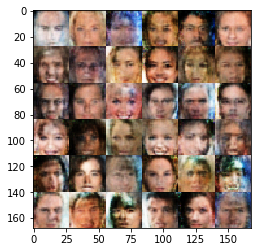

Epoch 1/1... Discriminator Loss: 0.9796351... Generator Loss: 1.2188939
Epoch 1/1... Discriminator Loss: 1.0126785... Generator Loss: 1.1907206
Epoch 1/1... Discriminator Loss: 0.9578266... Generator Loss: 1.6261350
Epoch 1/1... Discriminator Loss: 1.2686579... Generator Loss: 0.8290562
Epoch 1/1... Discriminator Loss: 1.0292079... Generator Loss: 1.2674211
Epoch 1/1... Discriminator Loss: 1.0625991... Generator Loss: 1.3674229
Epoch 1/1... Discriminator Loss: 0.8780594... Generator Loss: 1.6487474
Epoch 1/1... Discriminator Loss: 0.9854439... Generator Loss: 1.1470239
Epoch 1/1... Discriminator Loss: 1.0119356... Generator Loss: 1.2228187
Epoch 1/1... Discriminator Loss: 1.1126616... Generator Loss: 0.7914145


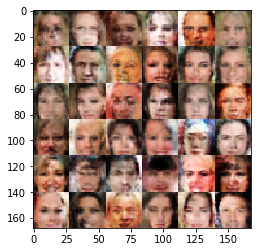

Epoch 1/1... Discriminator Loss: 1.0818517... Generator Loss: 1.0585624
Epoch 1/1... Discriminator Loss: 1.0110004... Generator Loss: 1.0851872
Epoch 1/1... Discriminator Loss: 0.9026717... Generator Loss: 1.1899095
Epoch 1/1... Discriminator Loss: 1.0328003... Generator Loss: 0.9782721
Epoch 1/1... Discriminator Loss: 1.1281300... Generator Loss: 0.7725360
Epoch 1/1... Discriminator Loss: 1.3971057... Generator Loss: 0.6487092
Epoch 1/1... Discriminator Loss: 1.0268562... Generator Loss: 1.0344938
Epoch 1/1... Discriminator Loss: 0.8939314... Generator Loss: 1.3231211
Epoch 1/1... Discriminator Loss: 1.0312600... Generator Loss: 1.1828976
Epoch 1/1... Discriminator Loss: 1.1917496... Generator Loss: 0.8600110


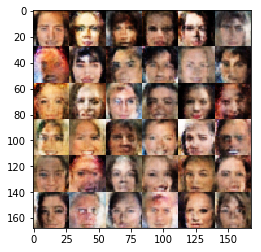

Epoch 1/1... Discriminator Loss: 1.0528610... Generator Loss: 0.8362603
Epoch 1/1... Discriminator Loss: 0.9721738... Generator Loss: 1.1260667
Epoch 1/1... Discriminator Loss: 0.7829149... Generator Loss: 1.3111302
Epoch 1/1... Discriminator Loss: 1.1903119... Generator Loss: 0.9647080
Epoch 1/1... Discriminator Loss: 1.0827584... Generator Loss: 0.9324837
Epoch 1/1... Discriminator Loss: 0.9391567... Generator Loss: 1.2408521
Epoch 1/1... Discriminator Loss: 1.2650733... Generator Loss: 0.7279996
Epoch 1/1... Discriminator Loss: 0.7115145... Generator Loss: 1.3843997
Epoch 1/1... Discriminator Loss: 0.9377275... Generator Loss: 1.4707125
Epoch 1/1... Discriminator Loss: 0.9264511... Generator Loss: 1.0673931


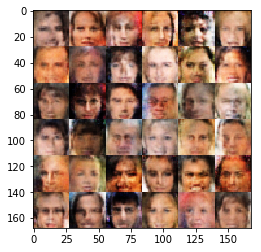

Epoch 1/1... Discriminator Loss: 1.2008204... Generator Loss: 0.7216651
Epoch 1/1... Discriminator Loss: 1.1954660... Generator Loss: 0.9110969
Epoch 1/1... Discriminator Loss: 1.0097258... Generator Loss: 1.2405119
Epoch 1/1... Discriminator Loss: 0.9628059... Generator Loss: 1.3893981
Epoch 1/1... Discriminator Loss: 0.9825355... Generator Loss: 1.2171680
Epoch 1/1... Discriminator Loss: 0.9314897... Generator Loss: 1.1436883
Epoch 1/1... Discriminator Loss: 1.0446408... Generator Loss: 0.8131346
Epoch 1/1... Discriminator Loss: 1.2699572... Generator Loss: 0.7028206
Epoch 1/1... Discriminator Loss: 1.5150939... Generator Loss: 0.4681035
Epoch 1/1... Discriminator Loss: 1.1812769... Generator Loss: 0.7185096


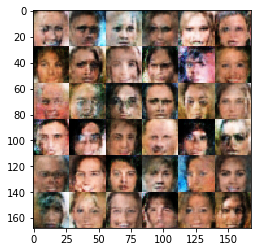

Epoch 1/1... Discriminator Loss: 1.0126338... Generator Loss: 1.0592436
Epoch 1/1... Discriminator Loss: 1.0618728... Generator Loss: 1.0745789
Epoch 1/1... Discriminator Loss: 0.9521909... Generator Loss: 1.0892799
Epoch 1/1... Discriminator Loss: 1.0980918... Generator Loss: 0.8596724
Epoch 1/1... Discriminator Loss: 1.5277017... Generator Loss: 2.4563670
Epoch 1/1... Discriminator Loss: 1.4781874... Generator Loss: 0.5786596
Epoch 1/1... Discriminator Loss: 0.9931916... Generator Loss: 1.3244128
Epoch 1/1... Discriminator Loss: 1.0513330... Generator Loss: 1.0162226
Epoch 1/1... Discriminator Loss: 1.1560998... Generator Loss: 0.9693578
Epoch 1/1... Discriminator Loss: 0.8072108... Generator Loss: 1.5079210


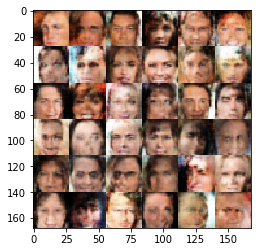

Epoch 1/1... Discriminator Loss: 1.1044049... Generator Loss: 0.8950067
Epoch 1/1... Discriminator Loss: 1.2796023... Generator Loss: 0.6278482
Epoch 1/1... Discriminator Loss: 1.0155939... Generator Loss: 0.9408224
Epoch 1/1... Discriminator Loss: 1.0801377... Generator Loss: 1.0656500
Epoch 1/1... Discriminator Loss: 0.9345069... Generator Loss: 1.7964389
Epoch 1/1... Discriminator Loss: 1.0328107... Generator Loss: 1.6203660
Epoch 1/1... Discriminator Loss: 1.0767035... Generator Loss: 0.9173733
Epoch 1/1... Discriminator Loss: 1.1758289... Generator Loss: 0.7795027
Epoch 1/1... Discriminator Loss: 0.8023496... Generator Loss: 1.5091684
Epoch 1/1... Discriminator Loss: 1.1857954... Generator Loss: 2.8118849


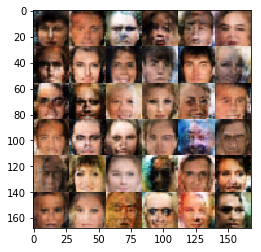

Epoch 1/1... Discriminator Loss: 1.1238507... Generator Loss: 0.8494147
Epoch 1/1... Discriminator Loss: 1.2333248... Generator Loss: 0.6386315
Epoch 1/1... Discriminator Loss: 0.9631249... Generator Loss: 1.1563580
Epoch 1/1... Discriminator Loss: 0.9753282... Generator Loss: 1.0967638
Epoch 1/1... Discriminator Loss: 1.0410991... Generator Loss: 0.9167466
Epoch 1/1... Discriminator Loss: 0.8570230... Generator Loss: 1.5421979
Epoch 1/1... Discriminator Loss: 0.9325925... Generator Loss: 1.1516908
Epoch 1/1... Discriminator Loss: 0.8607338... Generator Loss: 1.5526017
Epoch 1/1... Discriminator Loss: 0.8740370... Generator Loss: 1.1162473
Epoch 1/1... Discriminator Loss: 0.9428566... Generator Loss: 1.2761085


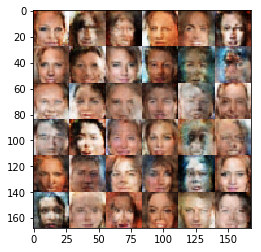

Epoch 1/1... Discriminator Loss: 0.9621977... Generator Loss: 1.4135869
Epoch 1/1... Discriminator Loss: 1.3468606... Generator Loss: 0.4997992
Epoch 1/1... Discriminator Loss: 1.0552009... Generator Loss: 1.1572406
Epoch 1/1... Discriminator Loss: 1.0753446... Generator Loss: 1.0860507
Epoch 1/1... Discriminator Loss: 1.0107723... Generator Loss: 1.5476669
Epoch 1/1... Discriminator Loss: 1.3790429... Generator Loss: 0.6000198
Epoch 1/1... Discriminator Loss: 0.9718877... Generator Loss: 1.5841044
Epoch 1/1... Discriminator Loss: 0.9935465... Generator Loss: 1.5271991
Epoch 1/1... Discriminator Loss: 1.0446033... Generator Loss: 1.0232954
Epoch 1/1... Discriminator Loss: 1.0420436... Generator Loss: 0.8743777


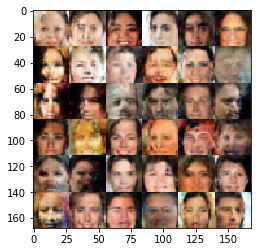

Epoch 1/1... Discriminator Loss: 0.9965729... Generator Loss: 1.1672981
Epoch 1/1... Discriminator Loss: 1.0264460... Generator Loss: 1.2162204
Epoch 1/1... Discriminator Loss: 0.9448233... Generator Loss: 1.0074568
Epoch 1/1... Discriminator Loss: 1.0728672... Generator Loss: 0.9942904
Epoch 1/1... Discriminator Loss: 1.0080909... Generator Loss: 1.0871457
Epoch 1/1... Discriminator Loss: 1.0315005... Generator Loss: 1.2675531
Epoch 1/1... Discriminator Loss: 1.0690753... Generator Loss: 1.0606083
Epoch 1/1... Discriminator Loss: 0.8717594... Generator Loss: 1.5145168
Epoch 1/1... Discriminator Loss: 0.9886308... Generator Loss: 1.1375713
Epoch 1/1... Discriminator Loss: 1.5199649... Generator Loss: 0.5163419


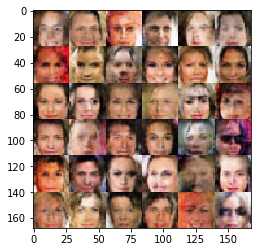

Epoch 1/1... Discriminator Loss: 1.3600543... Generator Loss: 0.7192742
Epoch 1/1... Discriminator Loss: 1.1360488... Generator Loss: 1.0362078
Epoch 1/1... Discriminator Loss: 0.8816693... Generator Loss: 1.1104864
Epoch 1/1... Discriminator Loss: 1.0739003... Generator Loss: 1.2380121
Epoch 1/1... Discriminator Loss: 1.1379199... Generator Loss: 0.7782224
Epoch 1/1... Discriminator Loss: 0.9918847... Generator Loss: 1.2412665
Epoch 1/1... Discriminator Loss: 1.0551410... Generator Loss: 1.2312386
Epoch 1/1... Discriminator Loss: 1.0951966... Generator Loss: 0.9440789
Epoch 1/1... Discriminator Loss: 0.8743492... Generator Loss: 0.9973961
Epoch 1/1... Discriminator Loss: 1.0392743... Generator Loss: 1.4593289


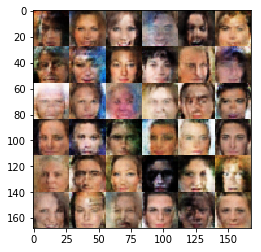

Epoch 1/1... Discriminator Loss: 1.1010489... Generator Loss: 1.8990721
Epoch 1/1... Discriminator Loss: 1.1531322... Generator Loss: 0.7444687
Epoch 1/1... Discriminator Loss: 1.2010891... Generator Loss: 0.7120396
Epoch 1/1... Discriminator Loss: 0.8469409... Generator Loss: 1.8077508
Epoch 1/1... Discriminator Loss: 1.1113060... Generator Loss: 0.8386204
Epoch 1/1... Discriminator Loss: 1.0892864... Generator Loss: 1.3226757
Epoch 1/1... Discriminator Loss: 0.9172755... Generator Loss: 1.2758869
Epoch 1/1... Discriminator Loss: 0.9996707... Generator Loss: 1.5372705
Epoch 1/1... Discriminator Loss: 1.0539825... Generator Loss: 1.0179439
Epoch 1/1... Discriminator Loss: 0.7921200... Generator Loss: 1.7734210


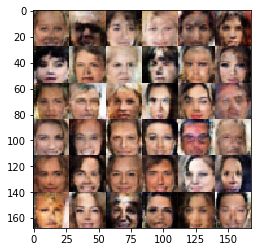

Epoch 1/1... Discriminator Loss: 1.3453425... Generator Loss: 0.7576029
Epoch 1/1... Discriminator Loss: 0.8512608... Generator Loss: 1.6553278
Epoch 1/1... Discriminator Loss: 1.0330286... Generator Loss: 0.8437099
Epoch 1/1... Discriminator Loss: 1.0053474... Generator Loss: 1.2518796
Epoch 1/1... Discriminator Loss: 0.9817724... Generator Loss: 1.4956381
Epoch 1/1... Discriminator Loss: 0.8937472... Generator Loss: 1.2375295
Epoch 1/1... Discriminator Loss: 1.3706515... Generator Loss: 0.6067637
Epoch 1/1... Discriminator Loss: 0.8473811... Generator Loss: 1.4572924
Epoch 1/1... Discriminator Loss: 1.0644302... Generator Loss: 1.1788938
Epoch 1/1... Discriminator Loss: 1.0083964... Generator Loss: 1.1001596


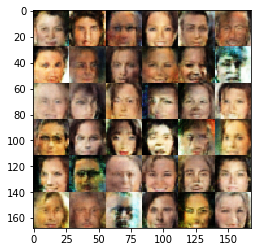

Epoch 1/1... Discriminator Loss: 1.1187987... Generator Loss: 1.0635881
Epoch 1/1... Discriminator Loss: 0.7490437... Generator Loss: 2.1455176
Epoch 1/1... Discriminator Loss: 0.9834958... Generator Loss: 0.8783466
Epoch 1/1... Discriminator Loss: 1.3320683... Generator Loss: 1.9700387
Epoch 1/1... Discriminator Loss: 0.9607161... Generator Loss: 1.6883018
Epoch 1/1... Discriminator Loss: 0.8096856... Generator Loss: 2.1445878
Epoch 1/1... Discriminator Loss: 0.9196973... Generator Loss: 1.3598070
Epoch 1/1... Discriminator Loss: 1.0628338... Generator Loss: 1.5286521
Epoch 1/1... Discriminator Loss: 1.0463921... Generator Loss: 1.4158075
Epoch 1/1... Discriminator Loss: 1.1948755... Generator Loss: 0.7592585


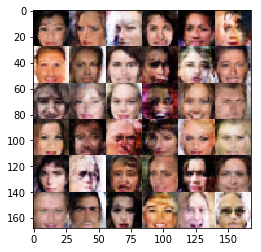

Epoch 1/1... Discriminator Loss: 1.3211696... Generator Loss: 2.0583205
Epoch 1/1... Discriminator Loss: 1.0314631... Generator Loss: 0.8652143
Epoch 1/1... Discriminator Loss: 1.0392736... Generator Loss: 1.4617579
Epoch 1/1... Discriminator Loss: 1.1444519... Generator Loss: 0.9747670
Epoch 1/1... Discriminator Loss: 1.0091399... Generator Loss: 1.1682551
Epoch 1/1... Discriminator Loss: 1.0276569... Generator Loss: 0.9634507
Epoch 1/1... Discriminator Loss: 1.0353657... Generator Loss: 0.8785159
Epoch 1/1... Discriminator Loss: 0.8756254... Generator Loss: 1.3907790
Epoch 1/1... Discriminator Loss: 1.1822737... Generator Loss: 0.9218801
Epoch 1/1... Discriminator Loss: 0.9721218... Generator Loss: 0.9287890


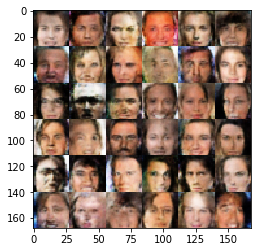

Epoch 1/1... Discriminator Loss: 1.0372076... Generator Loss: 1.0224577
Epoch 1/1... Discriminator Loss: 1.0730495... Generator Loss: 1.0303562
Epoch 1/1... Discriminator Loss: 0.8594162... Generator Loss: 1.4739637
Epoch 1/1... Discriminator Loss: 1.2175970... Generator Loss: 2.4249787
Epoch 1/1... Discriminator Loss: 1.1473482... Generator Loss: 1.4147594
Epoch 1/1... Discriminator Loss: 1.0931184... Generator Loss: 0.7526845


In [313]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

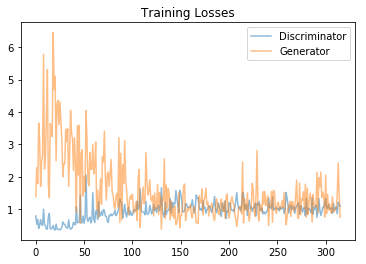

In [314]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()